In [1]:
%load_ext autoreload
%autoreload 2

# Unbiased ECMWF

Here we propose a small model which is a debiased ECMWF forecast according to the data we have.
The plan is
* Compute the bias between the ECMWF model and the observations
* Make a debiased model
* Turn this model into a probabilistic forecast
* Score the forecast
For now we do it only on temperature and weeks 3-4.

In [2]:
import dask
import dask.array as da
import dask.distributed
import dask_jobqueue
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import scipy.stats
import xarray as xr
import xskillscore as xs

In [3]:
from typing import Tuple

In [4]:
from crims2s.util import fix_dataset_dims

In [5]:
INPUT_TRAIN = '***BASEDIR***training-input/0.3.0/netcdf'
OBSERVATIONS = '***BASEDIR***training-output-reference/'
BENCHNMARK = '***BASEDIR***training-output-benchmark/'

## Boost dask cluster

In [6]:
def start_dask(user: str = "landryda", jobs: int = 2):
    
    if user == "landryda":
        cluster = dask_jobqueue.SLURMCluster(env_extra=['source ***HOME***.bash_profile','conda activate s2s'])
    elif user == "gierscjo":
        cluster = dask_jobqueue.SLURMCluster(cores=12,
                                             processes=6,
                                             memory='128G',
                                             env_extra=['source ***HOME***.bash_profile','conda activate s2s'],
                                             name='agri-dask',
                                             local_directory='***CACHE***', # METTRE VOTRE LOGIN CRIM ICI
                                             walltime='3:00:00')
    
    cluster.scale(jobs=jobs)  # Scale to two working nodes as configured.
    
    return dask.distributed.Client(cluster)

In [7]:
client = start_dask(user="gierscjo")

In [11]:
client

Client Scheduler: tcp://10.20.40.84:46272 Dashboard: http://10.20.40.84:8787/status,Cluster Workers: 12 Cores: 24 Memory: 238.44 GiB


## Generic Functions

In [12]:
def extract_train_validation_from_lead_time(xr_data, time_slice: slice = slice('14D', '27D')) -> Tuple:
    
    xr_data_sub = xr_data.sel(lead_time=time_slice)
    xr_data_sub_train = xr_data_sub.sel(forecast_year=slice(None, 2018))
    xr_data_sub_val = xr_data_sub.sel(forecast_year=slice(2019, None))
    
    return xr_data_sub, xr_data_sub_train, xr_data_sub_val

In [13]:
def compute_and_correct_bias(data_center_train, data_center_val, obs_train):
    
    bias = (obs_train - data_center_train).mean(dim=['lead_time', 'forecast_year'])
    corrected_bias = data_center_val + bias
    
    return bias, corrected_bias

## Read data

### ECMWF

In [45]:
CENTER = 'ecmwf'
FIELD = 't2m'

In [46]:
input_path = pathlib.Path(INPUT_TRAIN)

In [47]:
input_files = sorted([f for f in input_path.iterdir() if CENTER in f.stem and FIELD in f.stem])

In [48]:
input_files[:10]

[PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200102.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200109.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200116.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200123.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200130.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200206.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200213.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200220.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200227.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200305.nc')]

In [49]:
ecmwf = xr.open_mfdataset(input_files, preprocess=fix_dataset_dims)

In [ ]:
ecmwf_w34 = ecmwf.sel(lead_time=slice('14D', '27D'))
ecmwf_w34_train = ecmwf_w34.sel(forecast_year=slice(None, 2018))
ecmwf_w34_val = ecmwf_w34.sel(forecast_year=slice(2019, None))

ecmwf_w34, ecmwf_w34_train, ecmwf_w34_val = extract_train_validation_from_lead_time(ecmwf, time_slice=slice('14D', '27D'))

In [51]:
ecmwf_w34_train

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 19, latitude: 121, lead_time: 14, longitude: 240, realization: 11)
Coordinates:
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 14 days 15 days ... 27 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 19, 14), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(19, 1, 14, 11, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T16:32 GRIB to CDM+CF via cfgrib-0.9.9...

In [52]:
ecmwf_w34_val

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 14, longitude: 240, realization: 11)
Coordinates:
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 14 days 15 days ... 27 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 14), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 11, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T16:32 GRIB to CDM+CF via cfgrib-0.9.9...

### Observations

In [53]:
obs_path = pathlib.Path(OBSERVATIONS)
obs_files = [f for f in obs_path.iterdir() if 't2m' in f.stem]

In [54]:
obs = xr.open_mfdataset(obs_files, preprocess=fix_dataset_dims).isel(lead_time=slice(1, None))

In [ ]:
obs_w34_train = obs_w34.sel(forecast_year=slice(None, 2018))
obs_w34_val = obs_w34.sel(forecast_year=slice(2019, None))

In [56]:
obs_w34_val

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 14 days 15 days ... 27 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

## Debiasing

### Compute bias using training data

In [ ]:
ecmwf_w34_bias = (obs_w34_train - ecmwf_w34_train).mean(dim=['lead_time', 'forecast_year'])

### Bias correct ECMWF

In [ ]:
ecmwf_w34_val_corrected = ecmwf_w34_val + ecmwf_w34_bias

In [58]:
ecmwf_w34_bias

,Array,Chunk
Bytes,64.58 MiB,1.22 MiB
Shape,"(53, 121, 240, 11)","(1, 121, 240, 11)"
Count,1113 Tasks,53 Chunks
Type,float32,numpy.ndarray


### Get thresholds from train observations

In [60]:
obs_w34_train_thresholds = obs_w34_train.quantile([0.33, 0.66], dim=['lead_time', 'forecast_year'])

In [61]:
obs_w34_train_thresholds

,Array,Chunk
Bytes,23.49 MiB,453.75 kiB
Shape,"(2, 53, 121, 240)","(2, 1, 121, 240)"
Count,689 Tasks,53 Chunks
Type,float64,numpy.ndarray


### Compute p of thresholds according to the model

There are two ways to do this. 
We can either count the amount of members that are whithin each category.
Or compute a distribution of all the members of the model, and then compute the value of the CDF for each threshold.

Here we do it using the distribution method.

#### Compute a distribution of the members of the model

In [62]:
ecmwf_w34_val_corrected_mean = ecmwf_w34_val_corrected.mean(dim=['realization', 'lead_time'])
ecmwf_w34_val_corrected_std = ecmwf_w34_val_corrected.std(dim=['realization', 'lead_time'])

#### Compute the value of the CDF for each threshold

In [63]:
ecmwf_w34_val_corrected_mean

,Array,Chunk
Bytes,5.87 MiB,113.44 kiB
Shape,"(1, 53, 121, 240)","(1, 1, 121, 240)"
Count,1431 Tasks,53 Chunks
Type,float32,numpy.ndarray


In [64]:
def make_probabilistic(forecast, obs):
    thresholds = obs.quantile([0.33, 0.66], dim=['lead_time', 'forecast_year'])
    
    loc = forecast.mean(dim=['realization', 'lead_time']).compute().t2m
    scale = forecast.std(dim=['realization', 'lead_time']).compute().t2m
    
    cdfs = xr.apply_ufunc(scipy.stats.norm.cdf, thresholds.t2m, dask='allowed', kwargs={'loc': loc, 'scale': scale})
    
    below = cdfs.isel(quantile=0).drop_vars('quantile')
    normal = (cdfs.isel(quantile=1) - cdfs.isel(quantile=0))
    above = xr.ones_like(normal) - cdfs.isel(quantile=1).drop_vars('quantile')
    
    return xr.concat([below, normal, above], 'category').assign_coords(category=['below normal', 'near normal', 'above normal'])

In [65]:
val_probabilistic_forecast = make_probabilistic(ecmwf_w34_val_corrected, obs_w34_train)

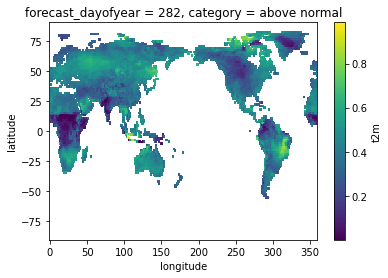

In [66]:
val_probabilistic_forecast.isel(category=2, forecast_dayofyear=40).plot()

In [67]:
loc = ecmwf_w34_val_corrected_mean.compute().t2m
scale = ecmwf_w34_val_corrected_std.compute().t2m

In [68]:
cdfs = xr.apply_ufunc(scipy.stats.norm.cdf, obs_w34_train_thresholds.t2m, dask='allowed', kwargs={'loc': loc, 'scale': scale})

(array([  435.,  1833.,  6776., 21843., 51089., 83826., 94498., 71157.,
        33759., 10236.]),
 array([0.00296365, 0.10266728, 0.20237092, 0.30207455, 0.40177819,
        0.50148182, 0.60118546, 0.70088909, 0.80059273, 0.90029636,
        1.        ]),
 <a list of 10 Patch objects>)

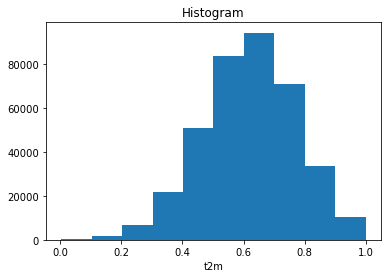

In [69]:
cdfs.isel(quantile=1).plot()

In [70]:
below = cdfs.isel(quantile=0).drop_vars('quantile')
normal = (cdfs.isel(quantile=1) - cdfs.isel(quantile=0))
above = xr.ones_like(normal) - cdfs.isel(quantile=1).drop_vars('quantile')

In [71]:
val_probabilistic_forecast = xr.concat([below, normal, above], 'category', coords='minimal').assign_coords(category=['below normal', 'near normal', 'above normal'])

### Sanity check

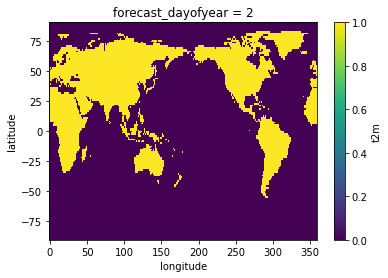

In [72]:
val_probabilistic_forecast.sum(dim='category').isel(forecast_dayofyear=0).plot()

## Score it

### Make a probabilistic version of the val obs

In [73]:
obs_w34_val

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 14 days 15 days ... 27 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [74]:
loc = obs_w34_val.mean(dim=['lead_time']).compute().t2m
scale = obs_w34_val.std(dim=['lead_time']).compute().t2m

In [75]:
cdfs = xr.apply_ufunc(scipy.stats.norm.cdf, obs_w34_train_thresholds.t2m, dask='allowed', kwargs={'loc': loc, 'scale': scale})

In [76]:
below = cdfs.isel(quantile=0).drop_vars('quantile')
normal = (cdfs.isel(quantile=1) - cdfs.isel(quantile=0))
above = xr.ones_like(normal) - cdfs.isel(quantile=1).drop_vars('quantile')

In [77]:
val_probabilistic_obs = xr.concat([below, normal, above], 'category').assign_coords(category=['below normal', 'near normal', 'above normal'])

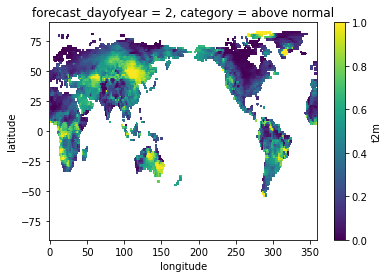

In [78]:
val_probabilistic_obs.isel(category=2, forecast_dayofyear=0).plot()

### Compare both proba using rps

In [79]:
val_probabilistic_obs

<xarray.DataArray 't2m' (category: 3, forecast_dayofyear: 53, latitude: 121, longitude: 240)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * category            (category) <U12 'below normal' ... 'above normal'

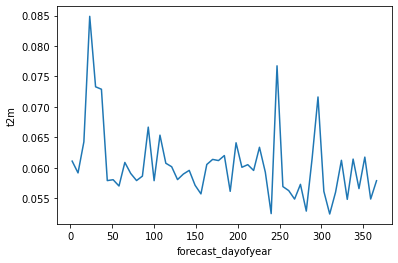

In [80]:
xs.rps(val_probabilistic_obs, val_probabilistic_forecast, category_edges=None, input_distributions='p', dim=['latitude', 'longitude']).plot()

## Process week 5-6

In [81]:
ecmwf_w56, ecmwf_w56_train, ecmwf_w56_val = extract_train_validation_from_lead_time(ecmwf, time_slice=slice('28D', '41D'))

In [82]:
obs_w56, obs_w56_train, obs_w56_val = extract_train_validation_from_lead_time(obs, time_slice=slice('28D', '41D'))

In [83]:
ecmwf_w56_bias, ecmwf_w56_val_corrected = compute_and_correct_bias(data_center_train=ecmwf_w56_train,
                                                                   data_center_val=ecmwf_w56_val, 
                                                                   obs_train=obs_w56_train)

In [84]:
obs_w56_train_thresholds = obs_w56_train.quantile([0.33, 0.66], dim=['lead_time', 'forecast_year'])

In [85]:
ecmwf_w56_val_corrected_mean = ecmwf_w56_val_corrected.mean(dim=['realization', 'lead_time'])
ecmwf_w56_val_corrected_std = ecmwf_w56_val_corrected.std(dim=['realization', 'lead_time'])

In [86]:
val_probabilistic_forecast_w56 = make_probabilistic(ecmwf_w56_val_corrected, obs_w56_train)

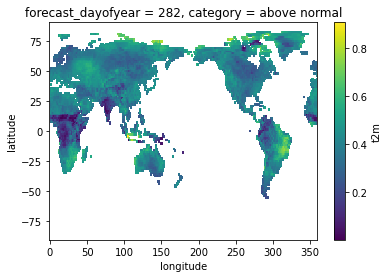

In [87]:
val_probabilistic_forecast_w56.isel(category=2, forecast_dayofyear=40).plot()

In [88]:
loc_w56 = ecmwf_w56_val_corrected_mean.compute().t2m
scale_w56 = ecmwf_w56_val_corrected_std.compute().t2m

In [89]:
cdfs_w56 = xr.apply_ufunc(scipy.stats.norm.cdf, obs_w56_train_thresholds.t2m, dask='allowed', kwargs={'loc': loc, 'scale': scale})

In [90]:
below_w56 = cdfs_w56.isel(quantile=0).drop_vars('quantile')
normal_w56 = (cdfs_w56.isel(quantile=1) - cdfs_w56.isel(quantile=0))
above_w56 = xr.ones_like(normal) - cdfs_w56.isel(quantile=1).drop_vars('quantile')

In [91]:
val_probabilistic_obs_w56 = xr.concat([below_w56, normal_w56, above_w56], 'category').assign_coords(category=['below normal', 'near normal', 'above normal'])

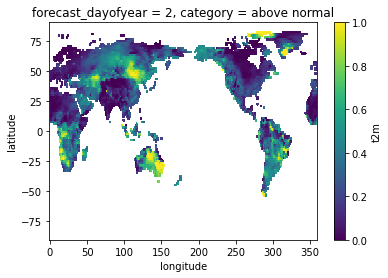

In [92]:
val_probabilistic_obs_w56.isel(category=2, forecast_dayofyear=0).plot()

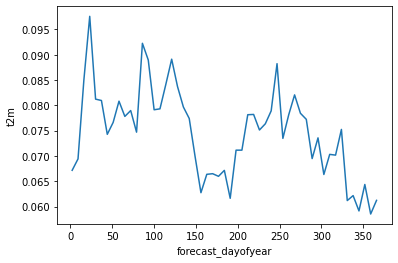

In [93]:
xs.rps(val_probabilistic_obs_w56, val_probabilistic_forecast, category_edges=None, input_distributions='p', dim=['latitude', 'longitude']).plot()

## Submission

### Example

In [152]:
benchmark_path = sorted([f for f in pathlib.Path(BENCHNMARK).iterdir() if FIELD in f.stem])[-1]
benchmark_path

PosixPath('***BASEDIR***training-output-benchmark/t2m.nc')

In [153]:
benchmark_example = xr.open_mfdataset([benchmark_path], preprocess=fix_dataset_dims)
benchmark_example

<xarray.Dataset>
Dimensions:             (category: 3, forecast_dayofyear: 1, forecast_year: 1079, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * category            (category) object 'below normal' ... 'above normal'
    forecast_time       (forecast_year) datetime64[ns] 2000-01-02 ... 2019-12-31
  * lead_time           (lead_time) timedelta64[ns] 14 days 28 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1079, 2), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, category, lead_time, latitude, longitude) float32 dask.array<chunksize=(1079, 1, 3, 2, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...

### Ours

In [166]:
val_probabilistic_obs_all = xr.concat([val_probabilistic_obs, val_probabilistic_obs_w56], "lead_time").to_dataset()

In [167]:
val_probabilistic_obs_all = val_probabilistic_obs_all.assign_coords(lead_time=np.array([14, 28], dtype='timedelta64[D]'))

In [168]:
val_probabilistic_obs_all.attrs = benchmark_example.attrs

In [169]:
val_probabilistic_obs_all

<xarray.Dataset>
Dimensions:             (category: 3, forecast_dayofyear: 53, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * category            (category) <U12 'below normal' ... 'above normal'
  * lead_time           (lead_time) timedelta64[ns] 14 days 28 days
Data variables:
    t2m                 (lead_time, category, forecast_dayofyear, latitude, longitude) float64 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-04T12:31 GRIB to CDM+CF via cfgrib-0.9.9...
    comment_lead_time:       The value of valid_time does not refer to the da...